# Exploratory Data Analysis

In [95]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
col_names = [   'unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'TRA',
                'T2', 'T24', 'T30', 'T50', 'P2',
                'P15', 'P30', 'Nf', 'Nc', 'epr',
                'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 
                'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31',
                'W32',
            ] 

In [19]:
# Importing Data for FD001

path_train_01 = r"/Users/Ameya/GitHub/TurboFanEngine_RUL-Estimator/Data/CMAPSSData/train_FD001.txt"
df_train_01 = pd.read_csv(path_train_01,
                 sep='\s+',
                 header=None,
                 index_col=False,
                 names=col_names
                 )

path_test_01 = r"/Users/Ameya/GitHub/TurboFanEngine_RUL-Estimator/Data/CMAPSSData/test_FD001.txt"
df_test_01 = pd.read_csv(path_test_01,
                 sep='\s+',
                 header=None,
                 index_col=False,
                 names=col_names
                 )

path_RUL_01 = r"/Users/Ameya/GitHub/TurboFanEngine_RUL-Estimator/Data/CMAPSSData/RUL_FD001.txt"
df_RUL_01 = pd.read_csv(path_RUL_01,
                 sep='\s+',
                 header=None,
                 index_col=False,
                 #names=col_names
                 )

In [72]:
df = df_train_01.copy()

def add_RUL(df):
    """
    Calculates maximum cycles run by every engine (unit number).
    Subtracts every cycle instance from max cycles and calculates remaining cycles for every engine
    """
    df_byUnit  = df.groupby(by='unit_number')
    max_cycles = df_byUnit['time_in_cycles'].max()
    df         = df.merge(max_cycles.to_frame(name='max_cycles'),
                         left_on = 'unit_number',
                         right_index = True
                         )
    df['RUL'] = df['max_cycles'] - df['time_in_cycles']
    return df

df = add_RUL(df)

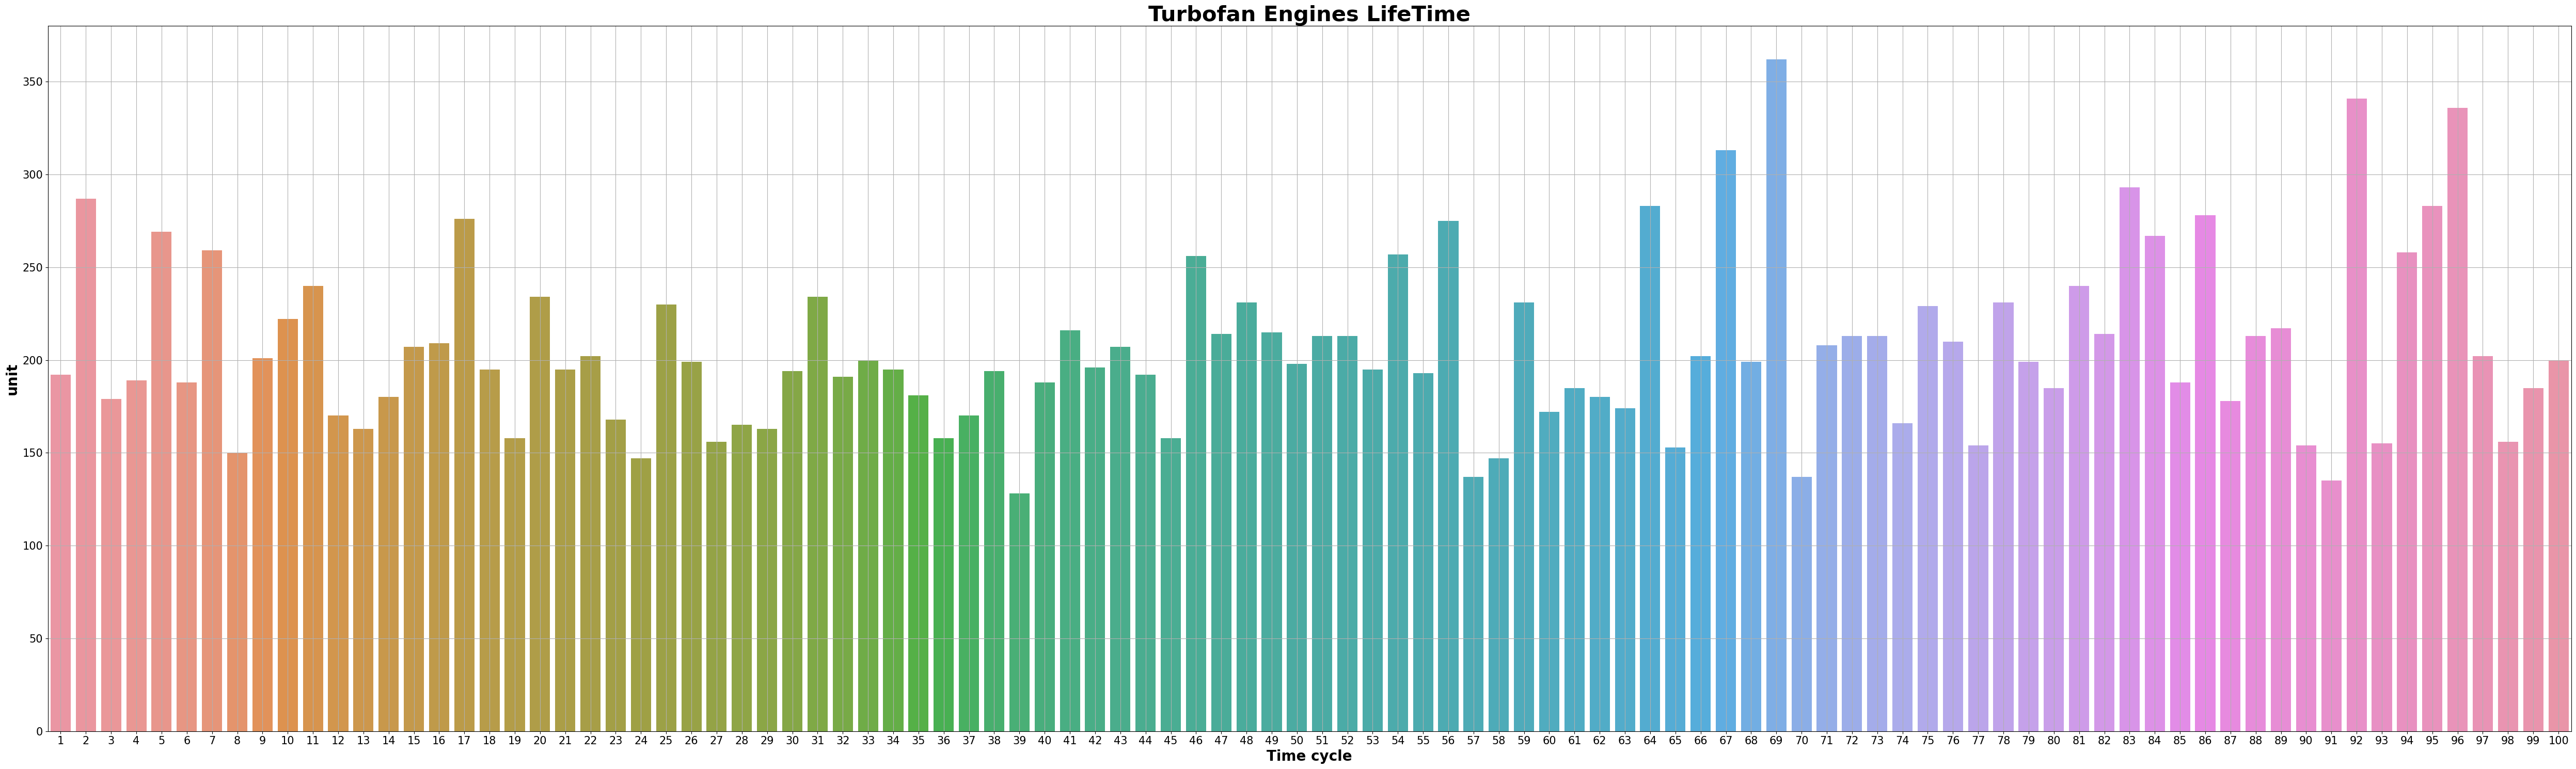

<Figure size 5000x1500 with 0 Axes>

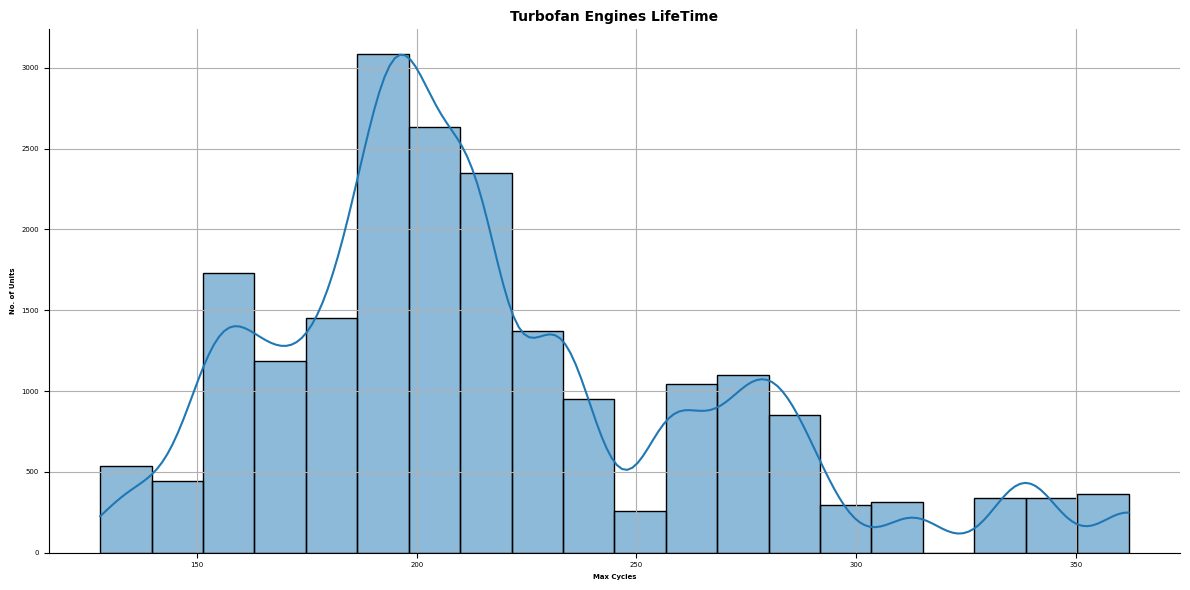

In [114]:
def plot_maxcycles(df):
    """
    1. Plots Engine number Vs. Max cycles run
    2. Frequency of max cycles
    """
    #Plot 1
    data = df[['unit_number', 'max_cycles']].groupby('unit_number').max()
    plt.figure(figsize=(50,15))
    sns.barplot(data=data,
                x = df['unit_number'],
                y = df['max_cycles'],
                )
    
    plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
    plt.xlabel('Time cycle',fontweight='bold',size=20); plt.xticks(size=15)
    plt.ylabel('unit',fontweight='bold',size=20); plt.yticks(size=15)
    plt.grid(True); plt.tight_layout(); plt.show()

    #Plot 2
    plt.figure(figsize=(50,15))
    sns.displot(df['max_cycles'],
                kde=True,
                bins=20,
                height=6,
                aspect=2
                )
    
    plt.title('Turbofan Engines LifeTime',fontweight='bold',size=10)
    plt.xlabel('Max Cycles',fontweight='bold',size=5); plt.xticks(size=5)
    plt.ylabel('No. of Units',fontweight='bold',size=5) ; plt.yticks(size=5)
    plt.grid(True); plt.tight_layout(); plt.show()

plot_maxcycles(df)

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


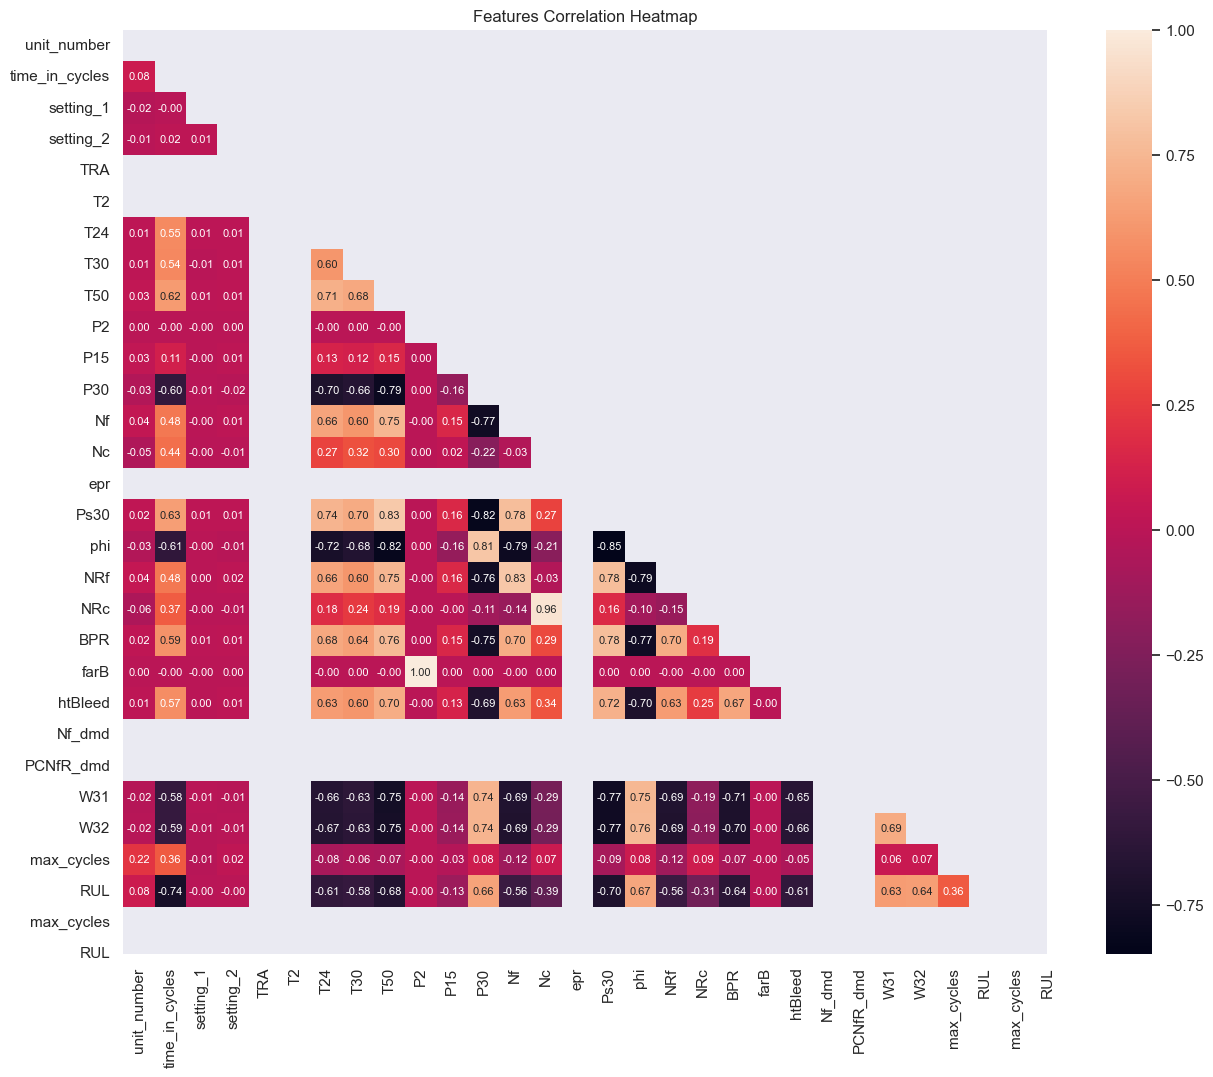

In [149]:
col_names = col_names + ['max_cycles', 'RUL']

import seaborn as sns
cm = np.corrcoef(df.values.T)
sns.set(font_scale=1.0)
mask = np.triu(np.ones_like(cm, dtype=bool))
fig = plt.figure(figsize=(15, 12))
hm = sns.heatmap(data = cm, 
                cbar=True, 
                annot=True, 
                square=True, 
                fmt='.2f', 
                annot_kws={'size': 8}, 
                yticklabels=col_names, xticklabels=col_names,
                mask = mask
                )
sns.color_palette("coolwarm", as_cmap=True)
plt.title('Features Correlation Heatmap')
plt.show()

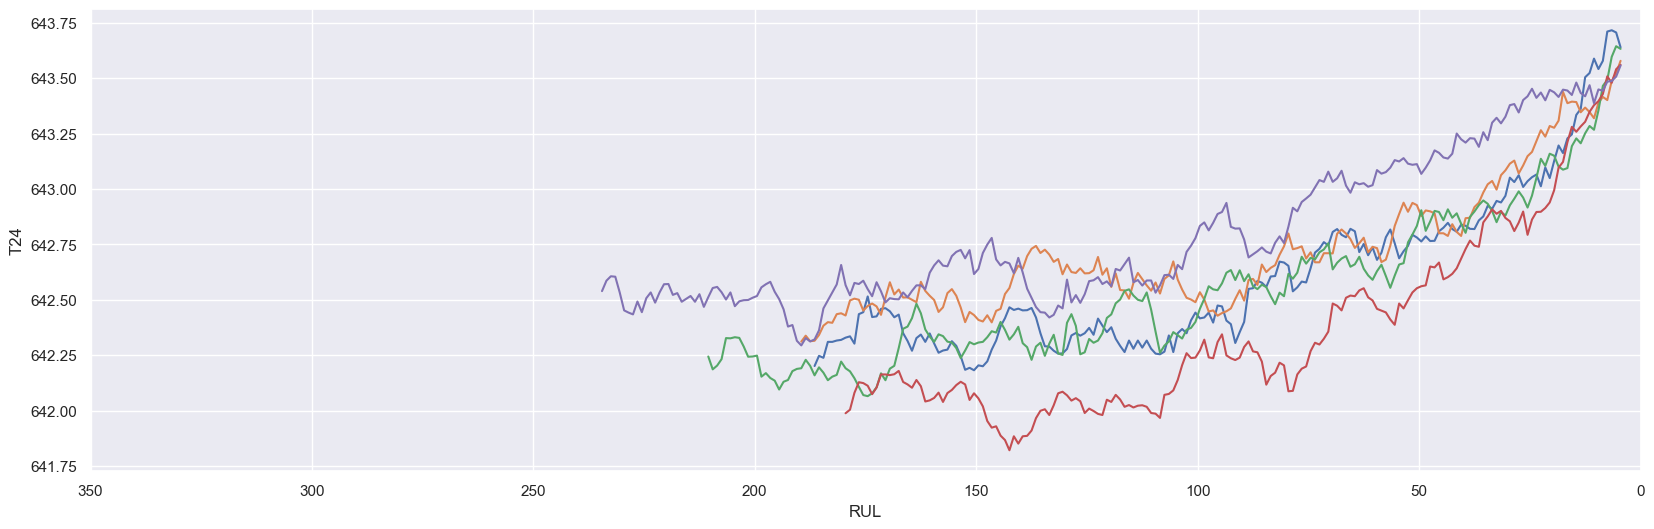

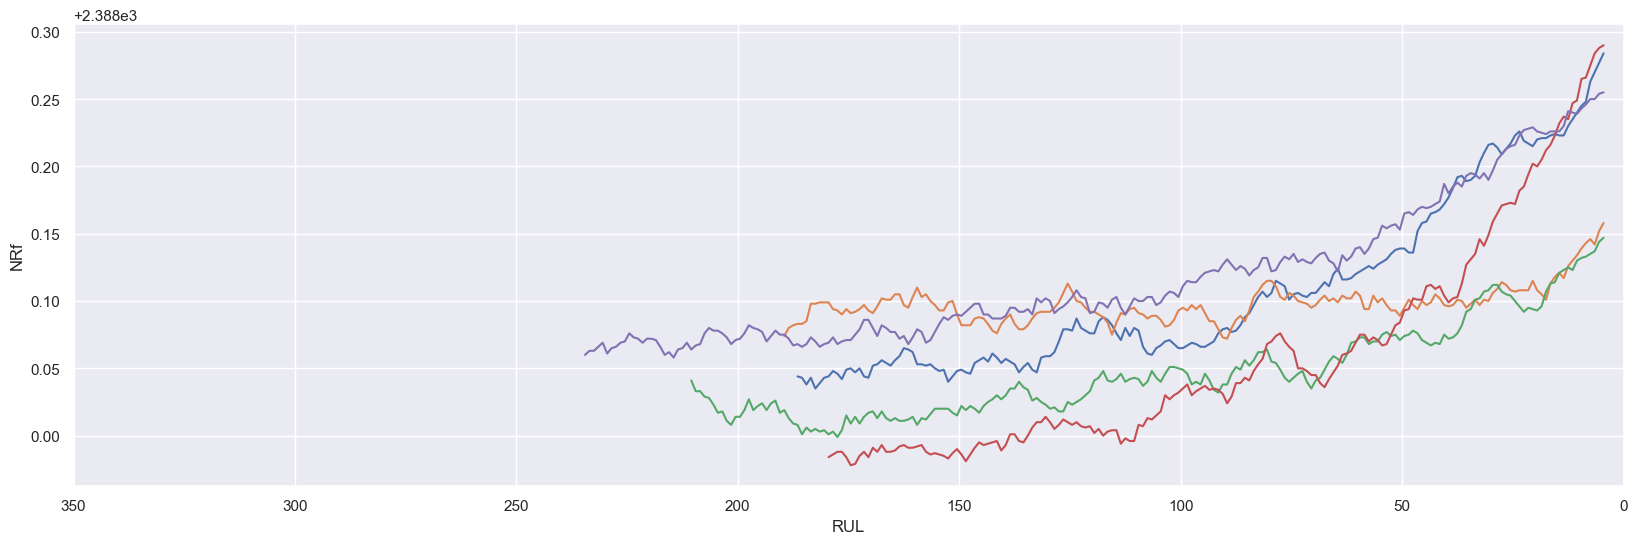

In [151]:
for  feature in ['T24', 'NRf']:
  fig = plt.figure(figsize=(20, 6)) 
  for unit in df['unit_number'].unique()[::20]:
    sns.lineplot(data = df,
            x = df[df['unit_number']==unit]['RUL'].rolling(10).mean(),
            y = df[df['unit_number']==unit][feature].rolling(10).mean(),
            #y = df['RUL'],
              )
    plt.xlim(350, 0),